### 這堂課目標
<li>Recurrent Neural Network  (RNN)</li>

- <a href="https://medium.com/@tengyuanchang/淺談遞歸神經網路-rnn-與長短期記憶模型-lstm-300cbe5efcc3">中文介紹</a>

- <a href="https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9">英文介紹</a>

- <a href="https://towardsdatascience.com/understanding-rnns-lstms-and-grus-ed62eb584d90">進化型：LSTM, GRU</a>


- <a href="https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/">這次範例程式出處</a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow.keras as keras

In [4]:
# fix random seed for reproducibility
np.random.seed(7)

In [181]:
# load the dataset
dataframe = pd.read_csv('airline-passengers.csv')
dataset = dataframe.Passengers.values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)
dataset[:10]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.]], dtype=float32)

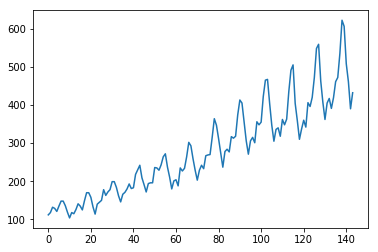

In [182]:
plt.plot(dataset)

In [19]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset[:10]


array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753]], dtype=float32)

In [20]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]



In [146]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [147]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)



In [148]:
# reshape input to be [samples, time steps, features]
#sample:幾筆資料
#time steps：每筆資料裡面有幾個時間性資料
#features：每筆資料裡面有幾個獨立特徵
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [149]:
# create and fit the LSTM network
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(4, input_shape=(look_back, 1)))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [150]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Train on 94 samples
Epoch 1/20
94/94 - 1s - loss: 0.0285
Epoch 2/20
94/94 - 0s - loss: 0.0121
Epoch 3/20
94/94 - 0s - loss: 0.0095
Epoch 4/20
94/94 - 0s - loss: 0.0076
Epoch 5/20
94/94 - 0s - loss: 0.0060
Epoch 6/20
94/94 - 0s - loss: 0.0047
Epoch 7/20
94/94 - 0s - loss: 0.0038
Epoch 8/20
94/94 - 0s - loss: 0.0033
Epoch 9/20
94/94 - 0s - loss: 0.0028
Epoch 10/20
94/94 - 0s - loss: 0.0025
Epoch 11/20
94/94 - 0s - loss: 0.0023
Epoch 12/20
94/94 - 0s - loss: 0.0021
Epoch 13/20
94/94 - 0s - loss: 0.0021
Epoch 14/20
94/94 - 0s - loss: 0.0021
Epoch 15/20
94/94 - 0s - loss: 0.0020
Epoch 16/20
94/94 - 0s - loss: 0.0020
Epoch 17/20
94/94 - 0s - loss: 0.0020
Epoch 18/20
94/94 - 0s - loss: 0.0021
Epoch 19/20
94/94 - 0s - loss: 0.0019
Epoch 20/20
94/94 - 0s - loss: 0.0020


In [151]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)



In [168]:
# invert predictions
trainPredict_invert = scaler.inverse_transform(trainPredict)
trainY_invert = scaler.inverse_transform([trainY])
testPredict_invert = scaler.inverse_transform(testPredict)
testY_invert = scaler.inverse_transform([testY])
dataset_invert = scaler.inverse_transform(dataset)


In [169]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_invert[0], trainPredict_invert[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_invert[0], testPredict_invert[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 22.87 RMSE
Test Score: 54.20 RMSE


In [170]:
# shift train predictions for plotting
trainPredictPlot = np.full_like(dataset, np.nan)
trainPredictPlot[look_back:len(trainPredict_invert)+look_back, :] = trainPredict_invert



In [171]:
# shift test predictions for plotting
testPredictPlot = np.full_like(dataset, np.nan)
testPredictPlot[len(trainPredict_invert)+(look_back*2)+1:len(dataset)-1, :] = testPredict_invert



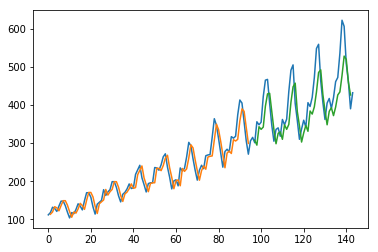

In [172]:
# plot baseline and predictions
plt.plot(dataset_invert)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### 更改項目：交叉測試，紀錄測試集的RMSE值

- RNN類型：SimpleRNN, LSTM, GRU
- timestep：1,2,5,10
- Features：1,2,5,10


In [173]:
import pandas as pd
row_index = ['SimpleRNN', 'LSTM', 'GRU']
column1_index = ['Timestep1', 'Timestep2', 'Timestep5', 'Timestep10', 
                 'Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5']
pd.DataFrame(index=row_index, columns=column1_index, data=0)